## User TimeLine Analysing

In [347]:
import tweepy
import pandas as pd
import re
import sqlite3
from pathlib import Path
import dateutil
import seaborn as sns

from matplotlib import pyplot

sns.set()
pd.set_option('display.max_colwidth', 50)

BASE_PATH = Path("DATASETS/usertimeline")

In [34]:
def db(df = None, name: str = "raw_data", open: bool = True):
    db_name = "usertimeline.db"
    con = sqlite3.connect(db_name)
    if open:
        df = pd.read_sql(f"select * from {name}", con)
        con.close()
        return df
    df.to_sql(name, con, index = False, if_exists='replace')
    con.close()

In [35]:
app_api_key = '-'
app_api_secret_key = '-'


auth = tweepy.AppAuthHandler(app_api_key, app_api_secret_key)

In [42]:
def get_tweets(username: str, count: int = 1000, remove_rt: bool = False, columns = ['created_at', 'full_text']):

    '''get tweets tweeted by specific user'''
    api = tweepy.API(
            auth,
            wait_on_rate_limit=True
        )

    tweets = tweepy.Cursor(
            api.user_timeline,
            screen_name = username,
            tweet_mode = 'extended',
            count = count
        ).items()
    
    tweets = [tweet._json for tweet in tweets]
    df = pd.json_normalize(tweets)
    df['created_at'] = pd.to_datetime(df['created_at'])
    
    if remove_rt:
        return df[~df['retweeted_status.id'].isna()][columns]
    return df[df['retweeted_status.id'].isna()][columns]


In [43]:
df = get_tweets('republic', 20000, False)
print(f"Tweets from: {df['created_at'].min()} to {df['created_at'].max()}")
print("Total tweets: ", len(df))

Tweets from: 2021-12-13 to 2021-12-24
Total tweets:  3246


In [54]:
df['length'] = df['full_text'].str.len()

In [55]:
df.sample(5)

,created_at,full_text,length
2403,2021-12-16,Australia to lift COVID restrictions despite r...,114
373,2021-12-23,#BREAKING | MHA to review J&amp;K security sit...,196
3102,2021-12-13,WATCH | PM Narendra Modi takes a boat ride fro...,193
828,2021-12-21,Canada's Foreign Affairs Min Melanie Joly test...,114
1497,2021-12-19,WATCH | PM Modi attends Goa's 60th Liberation...,217


In [56]:
print(df['full_text'][0])

#BREAKING | Harish Rawat to meet Congress top brass today amid ongoing crisis, informs sources.

Tune in to watch #LIVE here-

https://t.co/3AdouRdizw https://t.co/Mgp6b5XTHV


In [57]:
# Plotting value distribution

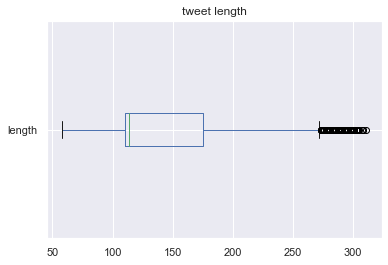

In [348]:
df['length'].plot.box(vert = False, title = "tweet length");

In [61]:
# we can see that 50 % of tweet have lenght between 110 and 170 characters, with median roughly 120

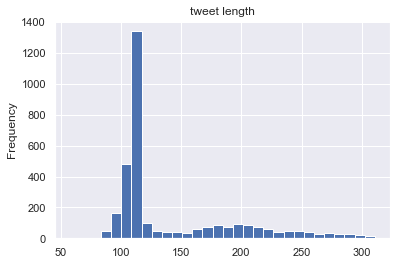

In [349]:
df['length'].plot.hist(bins = 30, title = 'tweet length');

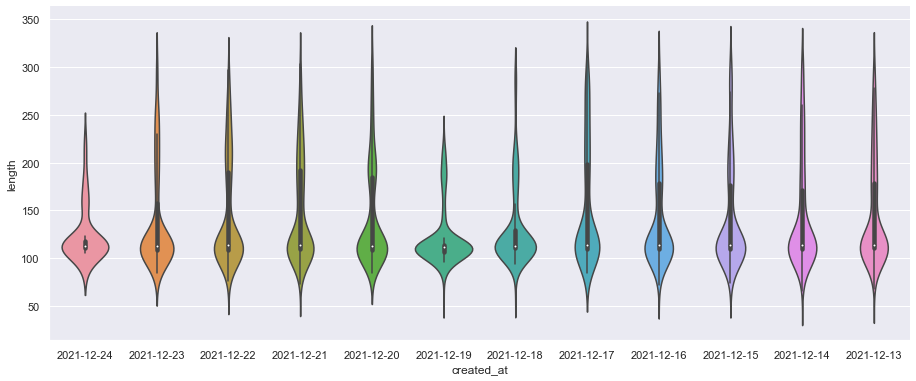

In [350]:
sns.catplot(data = df, x = 'created_at', y = 'length', kind = 'violin', height=5.27, aspect=12.7/5.27);

### Visualising top hash tags in 7 days

In [157]:
from collections import Counter
import re


In [282]:
def count(df, column = 'token', min_freq = 3, exclude_words = None):
    counter = Counter()
    df[column].map(counter.update)
    
    if exclude_words:
        for words in exclude_words: del counter[words]
    
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    return freq_df.sort_values('freq', ascending=False)

In [277]:
HASH_TAG_PATTERN = re.compile("#[\w\S]*")

def extract_hash_tags(doc):
    tags = re.findall(HASH_TAG_PATTERN, doc)
    if not tags: return "__NO_TAG__"
    return tags

In [278]:
df['hash_tags'] = df['full_text'].map(extract_hash_tags)

In [279]:
df.head(5)

,created_at,full_text,length,hash_tags
0,2021-12-24,#BREAKING | Harish Rawat to meet Congress top ...,174,"[#BREAKING, #LIVE]"
1,2021-12-24,'83' Twitter review: Netizens share opinions a...,110,__NO_TAG__
2,2021-12-24,"COVID-19: India reports 6,650 new infections i...",112,__NO_TAG__
3,2021-12-24,"#INDvsSA | Not Virat Kohli, but KL Rahul to ad...",106,[#INDvsSA]
4,2021-12-24,Rajasthan: Massive fire breaks out at chemical...,112,__NO_TAG__


In [286]:
hash_tags = df[df['hash_tags'] != '__NO_TAG__']

hash_tag_count_df = count(hash_tags, column='hash_tags', exclude_words=['#BREAKING', '#LIVE'])

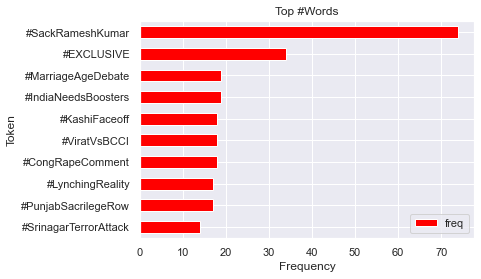

In [351]:
ax = hash_tag_count_df.head(10).plot.barh(width = .55, color = 'red')

ax.invert_yaxis()

ax.set(xlabel='Frequency', ylabel='Token', title='Top #Words');

## Visualizing top hash tags in each day

In [316]:
from wordcloud import WordCloud
from matplotlib import pyplot as plt

In [437]:
unique_date = df['created_at'].unique()

In [317]:
wc = WordCloud(max_words = 20)

In [444]:
def wordcloud_and_barplot(word_freq, title = None, max_words = 20):
    wc = WordCloud(width = 800, height=400, 
                   background_color="black", colormap="Paired",
                   max_font_size=100, max_words=max_words)
    counter = word_freq.to_dict()['freq']
    wc.generate_from_frequencies(counter)
    plt.figure(figsize=(20, 5))
    plt.suptitle(title, fontsize = 30)
    plt.subplot(121)
    sns.barplot(y = word_freq.index[:max_words], x = word_freq['freq'][:max_words], orient = 'h')
    plt.yticks(rotation=0, fontsize=15)
    plt.subplot(122)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

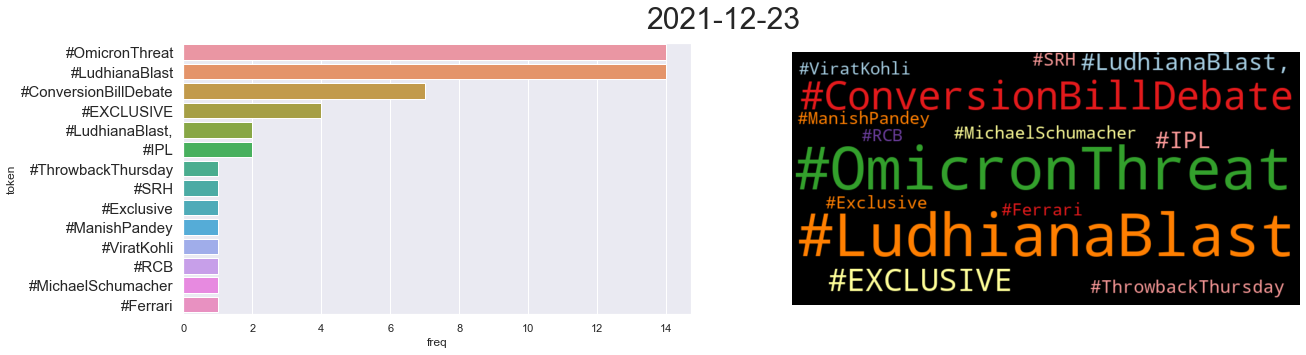

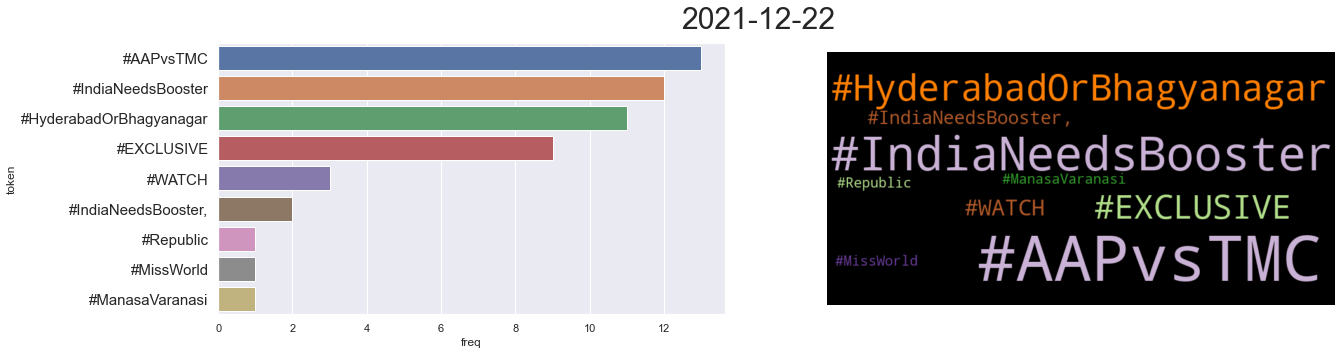

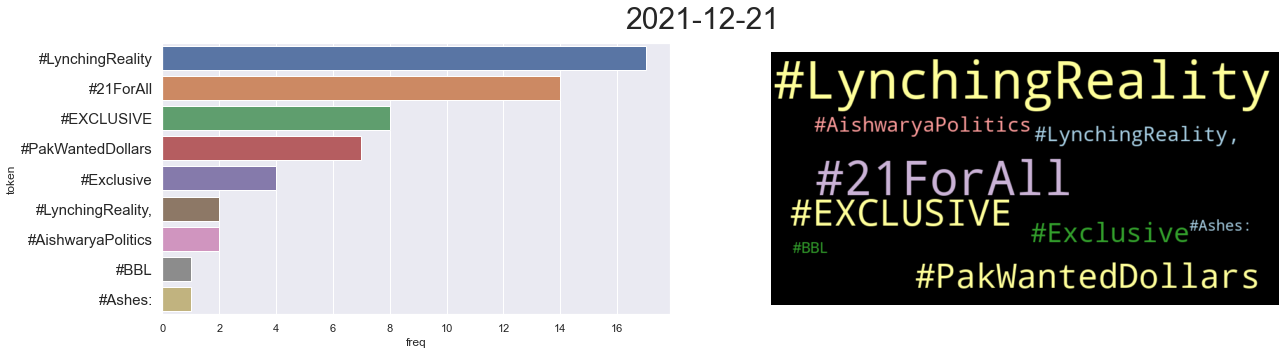

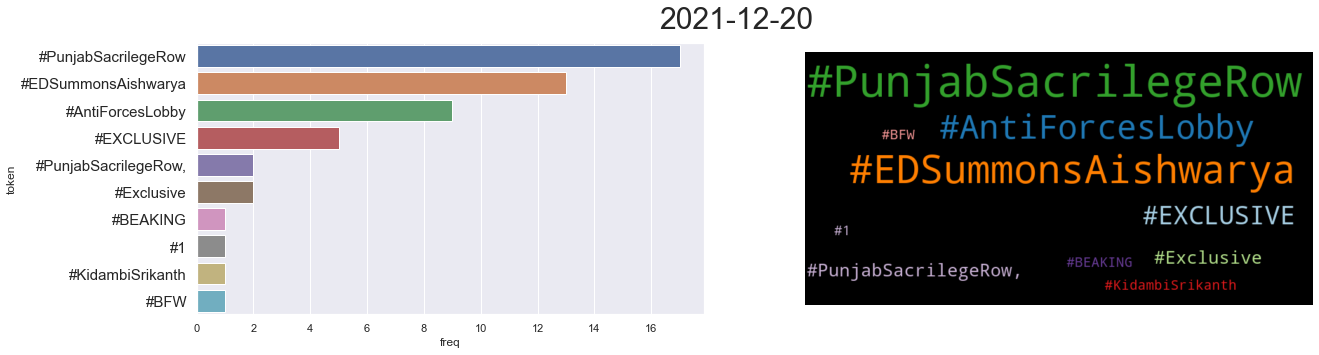

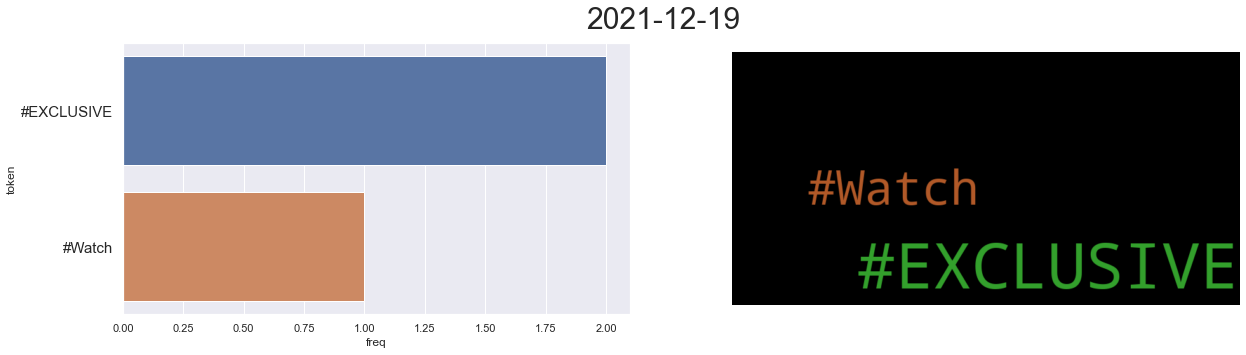

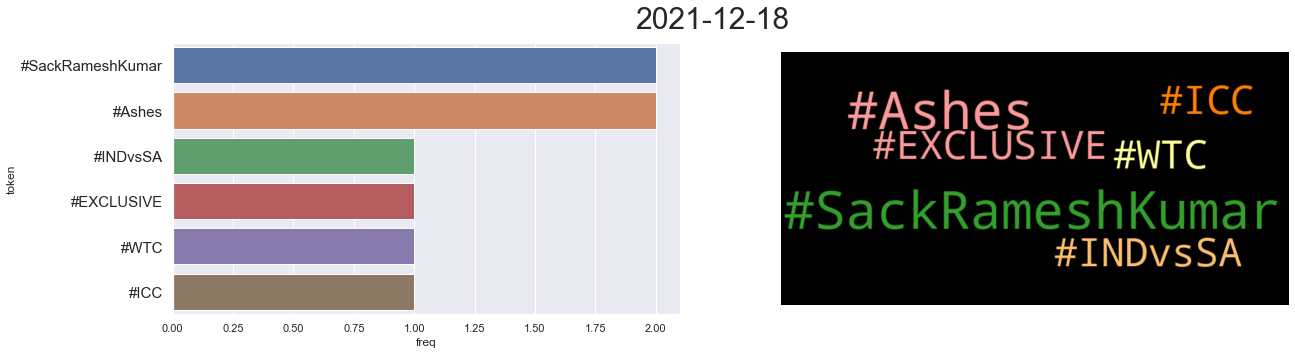

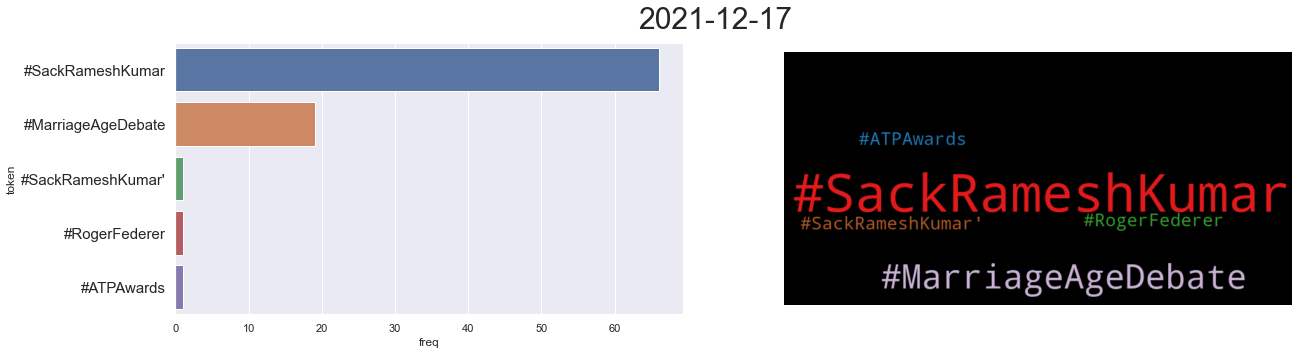

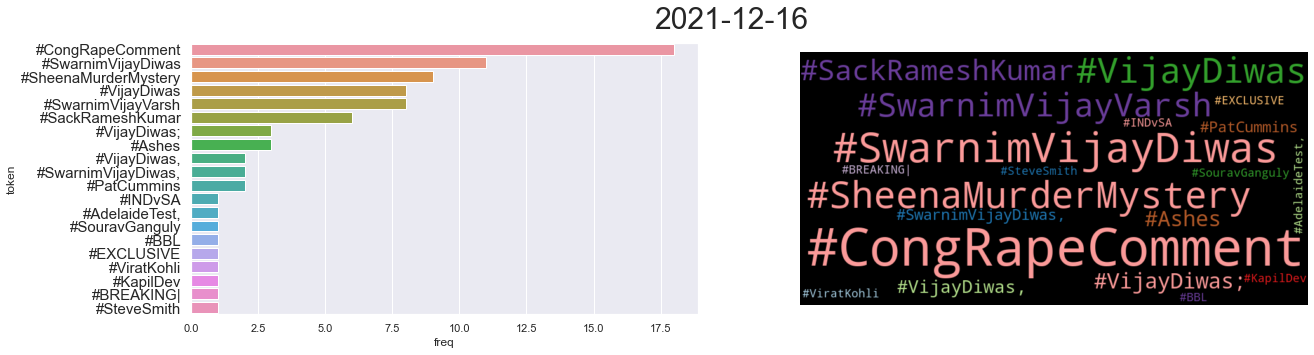

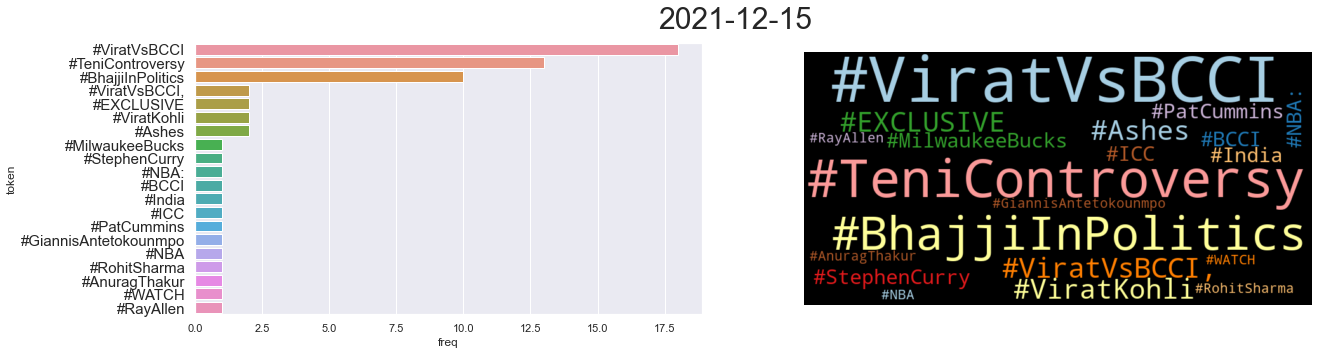

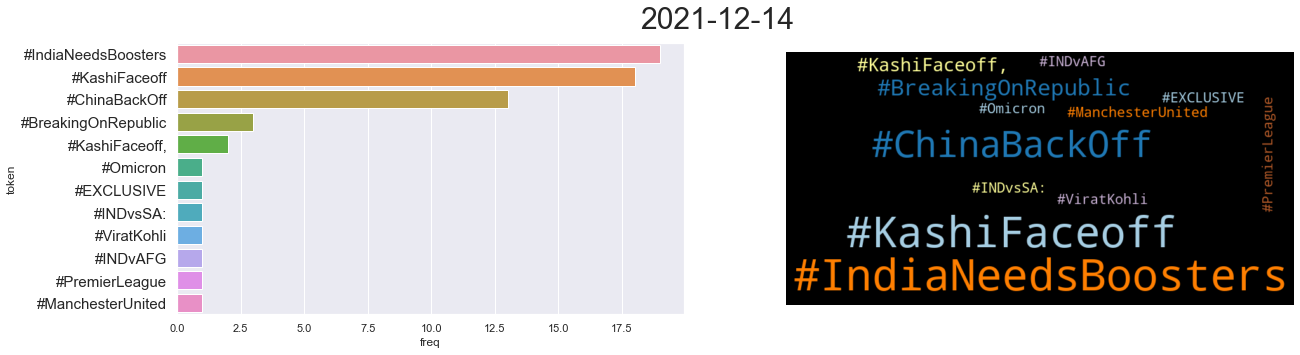

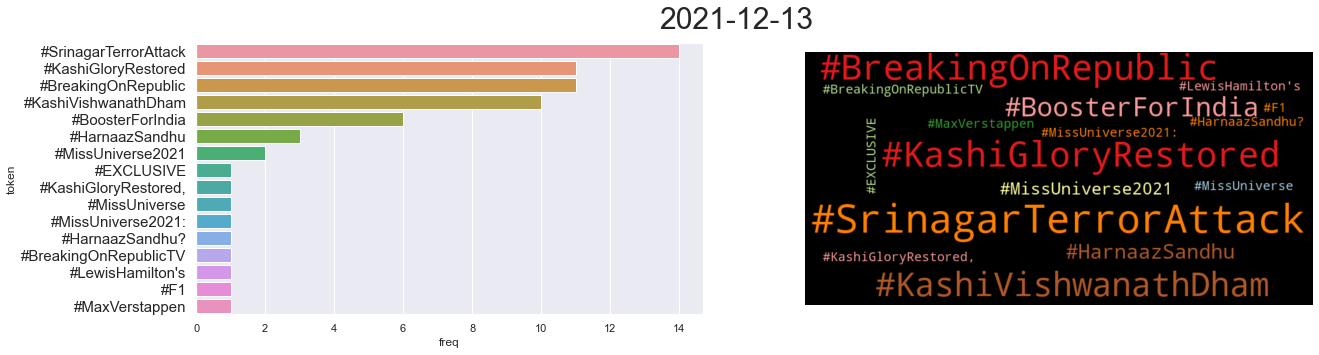

In [451]:
for date in unique_date:
    if date == '2021-12-24': continue
    where = df[(df['created_at'] == date) & (df['hash_tags'] != "__NO_TAG__")]
    freq_count = count(where, min_freq=1, column='hash_tags', exclude_words=['#BREAKING', '#LIVE', '#LIVE,', '#LIVE.', '#LIVE:', '#breaking', '#BREAKING:'])
    wordcloud_and_barplot(freq_count, title = date)
    print()
    
# 19th is sunday, so less debate 😂